# Étape 1: Prétraitement des données

In [ ]:
pip install pyodbc


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import pyodbc
from sklearn.preprocessing import LabelEncoder
# Paramètres de connexion à la base de données
server = 'DESKTOP-O7CGU5J\MSSQLSERVER2'
database = 'DW_HR_Projrct'
username = 'sa1'
password = 'sa@123@123'
driver = '{ODBC Driver 17 for SQL Server}'

# Chaîne de connexion
conn_str = f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}'

# Connectez-vous à la base de données
conn = pyodbc.connect(conn_str)

# Exécutez une requête SQL pour charger les données
sql_query = """
SELECT *
FROM Fact_charges
"""
data = pd.read_sql(sql_query, conn)

# Assurez-vous de fermer la connexion après les opérations
conn.close()

# Encodage des colonnes catégorielles

label_encoder_dep = LabelEncoder()
data['FK_Department_encoded'] = label_encoder_dep.fit_transform(data['FK_Department'])

label_encoder_emp = LabelEncoder()
data['FK_Employee_encoded'] = label_encoder_emp.fit_transform(data['FK_Employee'])

# Calculez la moyenne du RANK
average_rank = data['RANK'].mean()

# Filtrez les employés dont le RANK est inférieur à la moyenne
employees_below_average = data[data['RANK'] < average_rank].copy()

# Sélectionnez les colonnes pertinentes pour le clustering
features = employees_below_average[['FK_Department_encoded', 'HOURS', 'SALARY']]

# Normalisez les caractéristiques
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

C:\Users\khiar\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


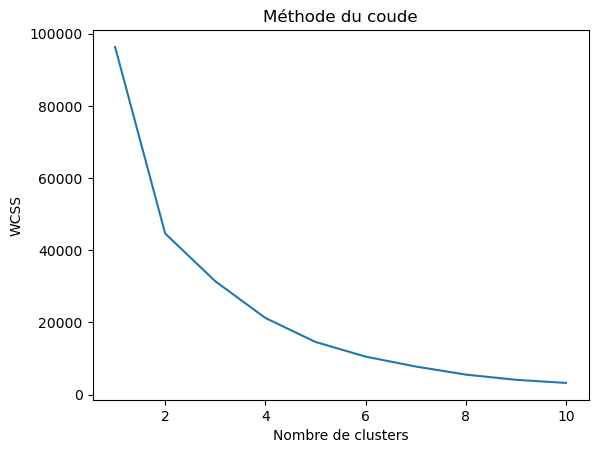

In [9]:
# Trouver le nombre optimal de clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Tracer le graphique du coude pour déterminer le nombre optimal de clusters
plt.plot(range(1, 11), wcss)
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')  # Within Cluster Sum of Squares (WCSS)
plt.show()

# Étape 2: Application de K-means

In [10]:
kmeans = KMeans(n_clusters=3, random_state=42)  # Vous pouvez choisir un nombre différent pour n_clusters
employees_below_average['cluster_kmeans'] = kmeans.fit_predict(features_scaled)
# Afficher les centres des clusters
print(kmeans.cluster_centers_)


[[-1.18919642 -0.81971892  1.02260015]
 [-0.04369174  0.7871904  -0.96135549]
 [ 0.72616161 -0.81971892  0.98921776]]


# Étape 3: Application de CAH

In [12]:
# Appliquez CAH
cah = AgglomerativeClustering(n_clusters=3)  # Assurez-vous que n_clusters correspond au nombre de clusters souhaité
employees_below_average['cluster_cah'] = cah.fit_predict(features_scaled)

# Étape 4: Visualisation des résultats K-means

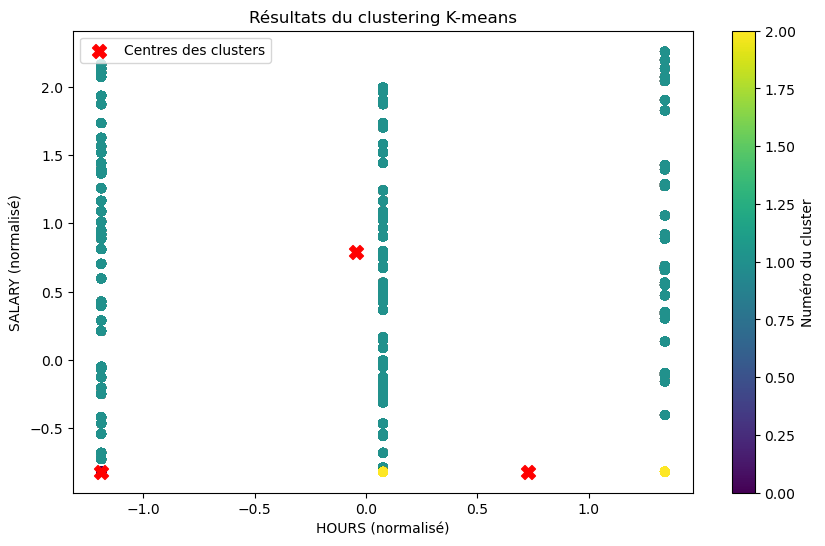

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=employees_below_average['cluster_kmeans'], cmap='viridis')
plt.title('Résultats du clustering K-means')
plt.xlabel('HOURS (normalisé)')
plt.ylabel('SALARY (normalisé)')
plt.colorbar(label='Numéro du cluster')

# Marquez les centres des clusters
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='X', label='Centres des clusters')

plt.legend()
plt.show()

Interprétation : 

- Cluster Jaune : Les employés dans ce cluster ont des heures travaillées autour de la moyenne et les salaires les plus bas par rapport aux autres clusters.
- Cluster Vert : Les employés ici ont également des heures travaillées autour de la moyenne mais des salaires légèrement plus élevés que le cluster jaune.
- Cluster Bleu : Les employés dans ce cluster travaillent un nombre d'heures plus élevé ou plus bas que la moyenne (comme le montrent les points étendus sur l'axe des abscisses) et ont les salaires les plus élevés.

# Étape 5: Visualisation des résultats CAH

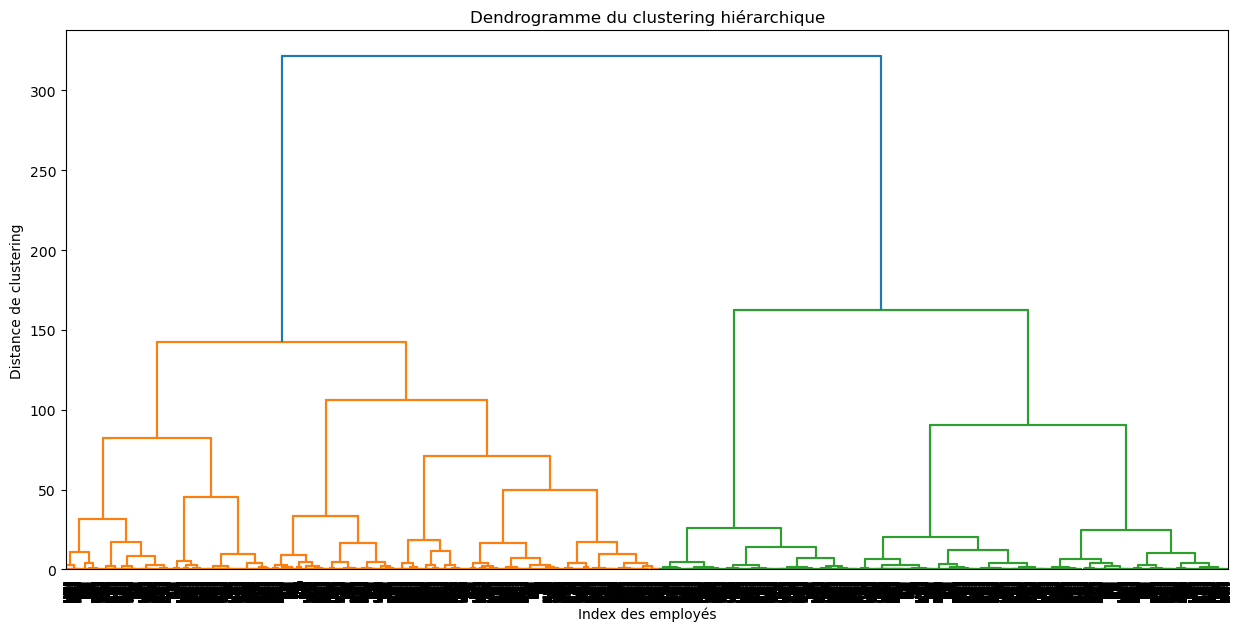

In [13]:
# Préparation des données pour le CAH
linkage_matrix = linkage(features_scaled, method='ward')

# Tracez le dendrogramme
plt.figure(figsize=(15, 7))
Z = linkage(features_scaled, method='ward')
dendrogram(Z, color_threshold=65)  
dendrogram(linkage_matrix)
plt.title('Dendrogramme du clustering hiérarchique')
plt.xlabel('Index des employés')
plt.ylabel('Distance de clustering')
plt.show()


Interprétation :

- Cluster avec des liens en bleu : Regroupe les employés qui sont très similaires entre eux, formant un cluster cohérent à une petite distance.
- Clusters avec des liens en orange, vert et rouge : Montrent des niveaux progressifs de regroupement, avec le cluster rouge représentant le regroupement le plus hétérogène, car il se forme à la plus grande distance.

Si on décidiee de couper le dendrogramme à une certaine hauteur, vous pourriez déterminer le nombre de clusters significatifs. Par exemple, une coupe à une hauteur d'environ 25 semble indiquer environ 2 clusters principaux (bien que cela soit un peu subjectif et pourrait être ajusté en fonction de l'interprétation désirée).